In [114]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

In [115]:
x_MainFoil, y_MainFoil = numpy.loadtxt('NACA23012_MainFoil.csv', delimiter=',', unpack=True)
x_FlapFoil, y_FlapFoil = numpy.loadtxt('NACA23012_FlapFoil.csv', delimiter=',', unpack=True)

(-0.5, 0.5)

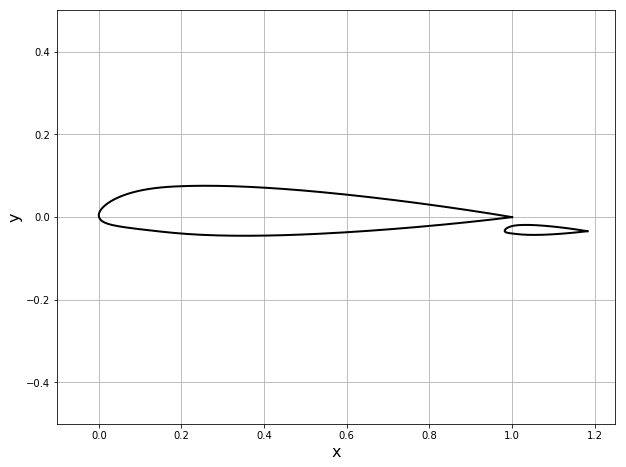

In [116]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_MainFoil, y_MainFoil, x_FlapFoil, y_FlapFoil, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.25)
pyplot.ylim(-0.5, 0.5)

In [117]:
def get_deflection_angle(X, Y, xd, yd, Bi):
    X = (X - xd) * numpy.cos(Bi) + (Y - yd) * numpy.sin(Bi) + 1.03
    Y = - (X - xd) * numpy.sin(Bi) + (Y - yd) * numpy.cos(Bi) - 0.054
    return X, Y

In [118]:
xd = 1.03
yd = -0.054
Bi = numpy.radians(-10)
X_FlapFoil, Y_FlapFoil = get_deflection_angle(x_FlapFoil, y_FlapFoil, xd, yd, Bi)

(-0.5, 0.5)

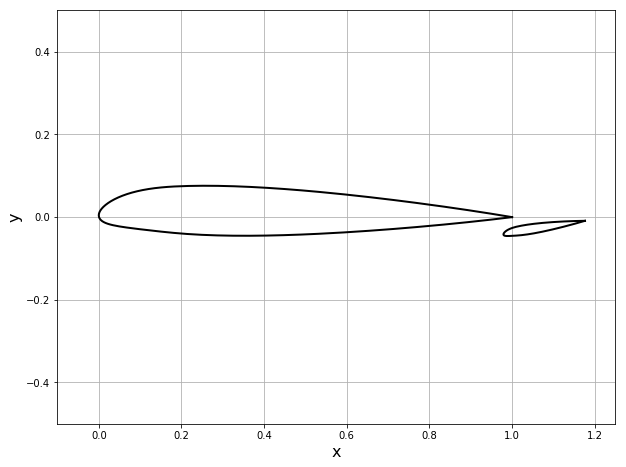

In [119]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_MainFoil, y_MainFoil, X_FlapFoil, Y_FlapFoil, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.25)
pyplot.ylim(-0.5, 0.5)

Class

In [120]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2)  
        
        if xb - xa <= 0.:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)
        
        if self.beta <= numpy.pi:
            self.loc = 'upper'  
        else:
            self.loc = 'lower'  
 
        self.sigma = 0.0  
        self.vt = 0.0  
        self.cp = 0.0

In [121]:
x_ends = x_MainFoil
y_ends = y_MainFoil

N = 150
panels = numpy.empty(N, dtype=object)
for i in range(N):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])

In [122]:
x_ends2 = X_FlapFoil
y_ends2 = Y_FlapFoil

N = 150
panels_fp = numpy.empty(N, dtype=object)
for i in range(N):
    panels_fp[i] = Panel(x_ends2[i], y_ends2[i], x_ends2[i + 1], y_ends2[i + 1])

In [123]:
class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)

In [124]:
def integral(x, y, panel, dxdz, dydz):
    def integrand(s):
        return (((x - (panel.xa - math.sin(panel.beta) * s)) * dxdz +
                (y - (panel.ya + math.cos(panel.beta) * s)) * dydz) /
                ((x - (panel.xa - math.sin(panel.beta) * s))**2 +
                (y - (panel.ya + math.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [125]:
def source_contribution_normal(panels, panels_fp):
    A = numpy.empty((panels.size + panels_fp.size, panels.size + panels_fp.size), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels_fp):
            A[i, 150 + j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    
    for i, panel_i in enumerate(panels_fp):
        for j, panel_j in enumerate(panels):
            A[i + 150, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    
    for i, panel_i in enumerate(panels_fp):
        for j, panel_j in enumerate(panels_fp):
            if i != j:
                A[i + 150, j + 150] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    
    return A

In [126]:
def vortex_contribution_normal(panels, panels_fp):
    A = numpy.empty((panels.size + panels_fp.size, panels.size + panels_fp.size), dtype=float)
    numpy.fill_diagonal(A, 0.0)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels_fp):
            A[i, 150 + j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    
    for i, panel_i in enumerate(panels_fp):
        for j, panel_j in enumerate(panels):
            A[i + 150, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    
    for i, panel_i in enumerate(panels_fp):
        for j, panel_j in enumerate(panels_fp):
            if i != j:
                A[i + 150, j + 150] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A

In [127]:
def build_b_matrix(panels, panels_fp, freestream):
    A = numpy.empty(panels.size + panels_fp.size, dtype=float)
    for i, panel in enumerate(panels):
        A[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    for j, panel in enumerate(panels_fp):
        A[150 + j] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    return A

In [128]:
def build_B_matrix(B_vortex):
    A = numpy.empty((A_source.shape[0], 2), dtype=float)
    A[:-100, 0] = numpy.sum(B_vortex[:-100, :-100], axis=1)
    A[:-100, 1] = numpy.sum(B_vortex[:-100, 100:], axis=1)
    A[100:, 0] = numpy.sum(B_vortex[100:, :-100], axis=1)
    A[100:, 1] = numpy.sum(B_vortex[100:, 100:], axis=1)
    return A

In [129]:
def build_singularity_matrix(A_source, B_vortex, B_B):
    A = numpy.empty((A_source.shape[0] + 2, A_source.shape[1] + 2), dtype=float)
    A[:-2, :-2] = A_source
    A[:-2, 300:] = B_B
    A[300:, :] = kutta_condition(A_source, B_vortex)
    return A

In [130]:
def build_freestream_rhs(panels, panels_fp, freestream, b_b):
    b = numpy.empty((panels.size + panels_fp.size + 2), dtype=float)
    b[:-2] = b_b
    b[-2] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels_fp[0].beta) +
                                 numpy.sin(freestream.alpha - panels_fp[-1].beta) )
    return b

In [131]:
def build_tangential_velocity_matrix(panels, panels_fp, A_source, B_vortex):
    A = numpy.empty((panels.size + panels_fp.size, panels.size + panels_fp.size + 2), dtype=float)
    A[:, :-2] = B_vortex
    A[:, -2] = -numpy.sum(A_source[:, :-150], axis=1)
    A[:, -1] = -numpy.sum(A_source[:, 150:], axis=1)
    return A

In [132]:
A_source = source_contribution_normal(panels, panels_fp)
B_vortex = vortex_contribution_normal(panels, panels_fp)

In [133]:
def kutta_condition(A_source, B_vortex):
    b = numpy.empty((2, A_source.shape[1] + 2), dtype=float)
    b[0, :-2] = B_vortex[0, :] + B_vortex[149, :]
    b[1, :-2] = B_vortex[150, :] + B_vortex[-1, :]
    b[0, -2] = - numpy.sum(A_source[0, :-150] + A_source[149, :-150])
    b[0, -1] = - numpy.sum(A_source[0, 150:] + A_source[149, 150:])
    b[1, -2] = - numpy.sum(A_source[150, :-150] + A_source[-1, :-150])
    b[1, -1] = - numpy.sum(A_source[150, 150:] + A_source[-1, 150:])
    return b

In [134]:
B_B = build_B_matrix(B_vortex)

In [135]:
A = build_singularity_matrix(A_source, B_vortex, B_B)

In [136]:
def build_freestream_tangential_velocity_rhs(panels, panels_fp, freestream):
    b = numpy.empty(panels.size + panels_fp.size, dtype=float)
    for i, panel in enumerate(panels):
        b[i] = freestream.u_inf * numpy.sin(freestream.alpha - panel.beta)
    for j, panel in enumerate(panels_fp):
        b[150 + j] = freestream.u_inf * numpy.sin(freestream.alpha - panel.beta)
    return b

In [137]:
def lift(alpha):
    u_inf = 1.0
    freestream = Freestream(u_inf, alpha)
    b_b = build_b_matrix(panels, panels_fp, freestream)
    A = build_singularity_matrix(A_source, B_vortex, B_B)
    b = build_freestream_rhs(panels, panels_fp, freestream, b_b)
    strengths = numpy.linalg.solve(A, b)
    for i, panel in enumerate(panels):
        panel.sigma = strengths[i]
    for j, panel in enumerate(panels_fp):
        panel.sigma = strengths[150 + j]
    gamma_main = strengths[-2]
    gamma_flap = strengths[-1]
    A_vt = build_tangential_velocity_matrix(panels, panels_fp, A_source, B_vortex)
    b_vt = build_freestream_tangential_velocity_rhs(panels, panels_fp, freestream)
    tangential_velocities = numpy.dot(A_vt, strengths) + b_vt
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
    for j, panel in enumerate(panels_fp):
        panel.vt = tangential_velocities[150 + j]
    for i, panel in enumerate(panels):
        panel.cp = 1.0 - (tangential_velocities[i] / freestream.u_inf)**2
    for j, panel in enumerate(panels_fp):
        panel.cp = 1.0 - (tangential_velocities[150 + j] / freestream.u_inf)**2
    c = abs(max(panel.xa for panel in panels) -
            min(panel.xa for panel in panels))
    cl = (gamma_main * sum(panel.length for panel in panels) /
          (0.5 * freestream.u_inf * c))
    c2 = abs(max(panel.xa for panel in panels_fp) -
             min(panel.xa for panel in panels_fp))
    cl2 = (gamma_flap * sum(panel.length for panel in panels_fp) /
           (0.5 * freestream.u_inf * c2))
    L = c * cl + c2 * cl2
    return L

In [ ]:
m = 1
a = -14
b = 14
alpha = 14

while abs(lift(alpha)) > 0.0001 and m < 100:
    if lift(alpha) < 0:
        a = alpha
    elif lift(alpha) > 0:
        b = alpha
    alpha = (a + b) / 2
    m += 1


print(alpha)

def lift(Bi):
    xd = 1.03
    yd = -0.054
    X_FlapFoil, Y_FlapFoil = get_deflection_angle(x_FlapFoil, y_FlapFoil, xd, yd, Bi)
    u_inf = 1.0
    freestream = Freestream(u_inf, alpha = 0.0)
    b_b = build_b_matrix(panels, panels_fp, freestream)
    A = build_singularity_matrix(A_source, B_vortex, B_B)
    b = build_freestream_rhs(panels, panels_fp, freestream, b_b)
    strengths = numpy.linalg.solve(A, b)
    for i, panel in enumerate(panels):
        panel.sigma = strengths[i]
    for j, panel in enumerate(panels_fp):
        panel.sigma = strengths[150 + j]
    gamma_main = strengths[-2]
    gamma_flap = strengths[-1]
    A_vt = build_tangential_velocity_matrix(panels, panels_fp, A_source, B_vortex)
    b_vt = build_freestream_tangential_velocity_rhs(panels, panels_fp, freestream)
    tangential_velocities = numpy.dot(A_vt, strengths) + b_vt
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
    for j, panel in enumerate(panels_fp):
        panel.vt = tangential_velocities[150 + j]
    for i, panel in enumerate(panels):
        panel.cp = 1.0 - (tangential_velocities[i] / freestream.u_inf)**2
    for j, panel in enumerate(panels_fp):
        panel.cp = 1.0 - (tangential_velocities[150 + j] / freestream.u_inf)**2
    c = abs(max(panel.xa for panel in panels) -
            min(panel.xa for panel in panels))
    cl = (gamma_main * sum(panel.length for panel in panels) /
          (0.5 * freestream.u_inf * c))
    c2 = abs(max(panel.xa for panel in panels_fp) -
             min(panel.xa for panel in panels_fp))
    cl2 = (gamma_flap * sum(panel.length for panel in panels_fp) /
           (0.5 * freestream.u_inf * c2))
    L = c * cl + c2 * cl2
    return L

In [138]:
print(lift(alpha = 0.0))

-0.0011842910451
